# Introduction

This is a first introduction to deep learning. We will focus on simple image classification tasks to gain experience with neural network architectures, model training and utilizing a deep learning framework. For the implementation we will use Keras, which enables us to create and train neural networks with just a few lines of code.

# Image Classification

## Dataset

In [2]:
from keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical

Keras provides easy access to one of the most used datasets, MNIST. This dataset consists of images of handwritten digits between 0 and 9 and the corresponding labels. The images are greyscale with 28x28 pixels.

Deep learning is all about generalization to the problem which we are trying to solve. To measure this we need to separate the dataset. We strictly split a training set and a test set. The **training set** is used for the learning progress. The **test set** is never used for training! It serves for estimating the final model, it therefore will provide an estimate for the model performance.
To find a good configuration during the learning phase an additional set is split from the training set, the **validation set**, this will be continuously monitored.


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


The data is provided as a numpy array. As a first step we want to investigate the data. Let's start with the dimensionality.

In [4]:
print("X -SHAPE", x_train.shape)
print("Y -SHAPE", y_train.shape)

X -SHAPE (60000, 28, 28)
Y -SHAPE (60000,)


There are 60000 samles. The x-data consists of the images each with 28x28 pixels.

In [5]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

The y-data consists of the corresponding labels. Digits from 0 to 9.

Lets plot the images with matplotlib, to get an idea of what we are dealing with.

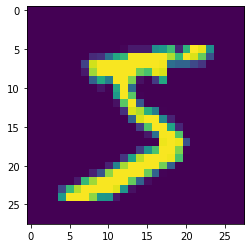

In [6]:
plt.imshow(x_train[0])
plt.show()

An important factor for the convergence of the network is the normalization of the input data, therefore we check the value range.

In [7]:
print("MAX-VALUE", np.max(x_train))
print("MIN-VALUE", np.min(x_train))

MAX-VALUE 255
MIN-VALUE 0


Large values can result in spikes during the training which disrupt the model. Small values make it easier for the model to adjust, therefore we normalize the data to the interval [-1, 1] to benefit the convergence.

In [8]:
norm_x_train = (x_train - 127.5) / 127.5

Images are provided with there channels as large dimension. For RGB = 3, greyscale = 1. Therefore we reshape each image from (28, 28) to (28, 28, 1).

In [9]:
norm_x_train = norm_x_train.reshape((-1, 28, 28, 1))
norm_x_train.shape

(60000, 28, 28, 1)

The target values (y-train) consists of digits. A very poor approach would be to predict the number directly:
1.   There is no relation between appearance and value of the digits
2.   Regression problems are hard to train

We therefore discritize the values into 10 categories. The output corresponds then to probability for each category:

3 --> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

0 --> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

8 --> [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

Keras provides a build in util for this task.

In [10]:
categorical_y_train = to_categorical(y_train, 10)
categorical_y_train.shape

(60000, 10)

We apply the same procedure for the test data

In [11]:
norm_x_test = (x_test - 127.5) / 127.5
norm_x_test = norm_x_test.reshape((-1, 28, 28, 1))
categorical_y_test = to_categorical(y_test, 10)

Let us check the images and the value range.

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


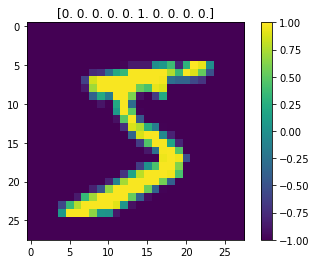

In [12]:
plt.imshow(norm_x_train[0,...,0])
plt.colorbar()
plt.title(categorical_y_train[0])
plt.show()

## Deep Learning Model

In [13]:
from keras.layers import Flatten, Dense, Input
from keras import Model
from tensorflow.keras.optimizers import Adam

Keras provides a very convenient way to create deep learning models. We only have to specify the input shape and the layers within the network. Each layer corresponds to a certain operation. We will start with a simple model where each neuron is connected with each neuron of the previous layer. This is called a dense or feed-forward network. The problem is that our input is not flat (28, 28, 1), therefore we have to transform the image in a first step into a vector of size (784,).


The value after each layer is defined by the matrix multiplication with the weights of the layer and an activation function. There is a large set of different activation functions available (https://keras.io/activations/). The commonly used activation functions are ReLU, Tanh and Sigmoid. 

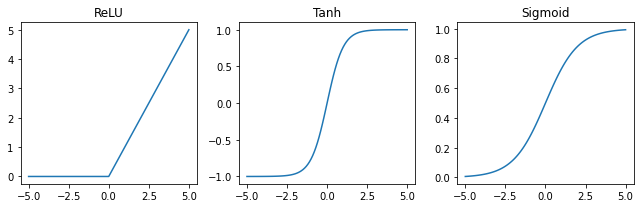

In [14]:
x = np.arange(-5, 5.1, 0.1)

relu = np.where(x < 0,0,x)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.title("ReLU")
plt.plot(x, relu)


plt.subplot(1, 3, 2)
plt.title("Tanh")
plt.plot(x, np.tanh(x))

plt.subplot(1, 3, 3)
plt.title("Sigmoid")
plt.plot(x, 1/(1+np.exp(-x)))

plt.tight_layout()

The activation functions within the network are arbitrary (choose what leads to the best performance). Contrarily the activation function of the output is important.


*   Regression (predict values): linear/no activation
*   Single Classification: sigmoid [0, 1] --> defines probability to be class 1 or 2 where 0.5 defines the border
*   Normalized Output (e.g. images): tanh, sigmoid
*   Multi-Class Classification: softmax (probabilities per class sum to 1)

These additional restrictions prevent that the network has to learn the output representation. In our case we are using a softmax as output activation and ReLU everywhere else.

In [15]:
img = Input((28, 28, 1))
x = Flatten()(img)
x = Dense(64, activation="relu")(x)
x = Dense(10, activation="softmax")(x)
model = Model(img, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


Next we have to define the loss function to use (e.g. mean-squared-error, mean-absolute-error, cross-entropy).

The learning rate defines the parameter change per update step. If the learning rate is too low the convergence takes long (the minimum is approached very slowly). If the learning rate is too large, oscillations around the minimum or divergences can occur.

For the update of the tunable parameters (weights) different algorithms can be used. Stochastic-Gradient-Descent is the simplest approach. Adam provides adaptive learning rates for each weight, which can significantly increase the convergence.

![alt text](https://cdn-images-1.medium.com/max/1600/1*Y2KPVGrVX9MQkeI8Yjy59Q.gif)

The batch size defines the samples which are simultaneously being processed. It should be rather large to increase the training speed and to efficiently use the computational resources (GPU). Additional the update based on multiple samples leads to a smoother convergence and a better generalization.

An epoch defines a full run through the dataset.

In [16]:
opt = Adam(0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])
history = model.fit(norm_x_train, categorical_y_train, epochs=50, batch_size=512, validation_split=0.2)

Epoch 1/50
94/94 [==============================] - 2s 6ms/step - loss: 0.7445 - categorical_accuracy: 0.7784 - val_loss: 0.3582 - val_categorical_accuracy: 0.8988
Epoch 2/50
94/94 [==============================] - 0s 4ms/step - loss: 0.3431 - categorical_accuracy: 0.9012 - val_loss: 0.2966 - val_categorical_accuracy: 0.9162
Epoch 3/50
94/94 [==============================] - 0s 4ms/step - loss: 0.2905 - categorical_accuracy: 0.9154 - val_loss: 0.2566 - val_categorical_accuracy: 0.9259
Epoch 4/50
94/94 [==============================] - 0s 5ms/step - loss: 0.2571 - categorical_accuracy: 0.9250 - val_loss: 0.2354 - val_categorical_accuracy: 0.9333
Epoch 5/50
94/94 [==============================] - 0s 4ms/step - loss: 0.2314 - categorical_accuracy: 0.9326 - val_loss: 0.2123 - val_categorical_accuracy: 0.9398
Epoch 6/50
94/94 [==============================] - 0s 4ms/step - loss: 0.2072 - categorical_accuracy: 0.9401 - val_loss: 0.1952 - val_categorical_accuracy: 0.9440
Epoch 7/50
94/94

From the comperisson of the training loss and the validation loss we can estimate the performance of the network. Remember that the final goal is generalization, the important quantity which we are trying to minimize is therefore the validation loss/accurarcy.

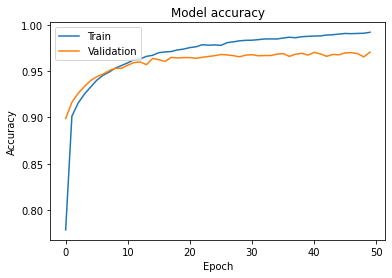

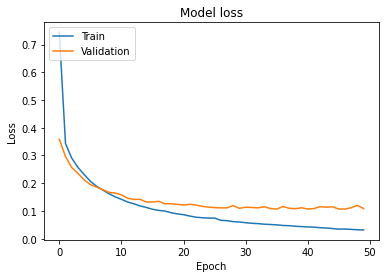

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

From this we can see that the model starts to performs better on the training data (overfitting) after about 10 epochs. After ~27 epochs there is no performance increase on the validation set. We rebuild the model and train on the full set for the final evaluation (no validation set). We stop the training after 27 epochs to approximitaly reach the point of best performance.

In [18]:
img = Input((28, 28, 1))
x = Flatten()(img)
x = Dense(64, activation="relu")(x)
x = Dense(10, activation="softmax")(x)
model = Model(img, x)
opt = Adam(0.001)
model.compile(loss="categorical_crossentropy",optimizer=opt, metrics=["categorical_accuracy"])
history = model.fit(norm_x_train, categorical_y_train, epochs=27, batch_size=512, validation_split=0)

Epoch 1/27
118/118 [==============================] - 1s 4ms/step - loss: 0.6851 - categorical_accuracy: 0.7968
Epoch 2/27
118/118 [==============================] - 0s 3ms/step - loss: 0.3201 - categorical_accuracy: 0.9073
Epoch 3/27
118/118 [==============================] - 0s 3ms/step - loss: 0.2667 - categorical_accuracy: 0.9233
Epoch 4/27
118/118 [==============================] - 0s 3ms/step - loss: 0.2310 - categorical_accuracy: 0.9329
Epoch 5/27
118/118 [==============================] - 0s 3ms/step - loss: 0.2069 - categorical_accuracy: 0.9400
Epoch 6/27
118/118 [==============================] - 0s 3ms/step - loss: 0.1832 - categorical_accuracy: 0.9469
Epoch 7/27
118/118 [==============================] - 0s 3ms/step - loss: 0.1694 - categorical_accuracy: 0.9503
Epoch 8/27
118/118 [==============================] - 0s 3ms/step - loss: 0.1545 - categorical_accuracy: 0.9549
Epoch 9/27
118/118 [==============================] - 0s 3ms/step - loss: 0.1445 - categorical_accuracy:

In [19]:
model.evaluate(norm_x_test, categorical_y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1039 - categorical_accuracy: 0.9680


[0.10386313498020172, 0.9679999947547913]

This is already a very good result for this approach, but can we do better?

## Convolutional Neural Network

In [20]:
from keras.layers import MaxPooling2D, Conv2D, Dropout

Convolutional neural networks (CNN) share parameters across space. The idea is that spatially close pixels are stronger related than distant pixels. The image is estimated step by step where the spatial dimensionality is consecutively reduced while the depth is increased. This corresponds to a transformation into the feature space of the image, where there is no spatial information.

The most important terms are:
*   Filters
*   Kernel
*   Striding
*   Padding



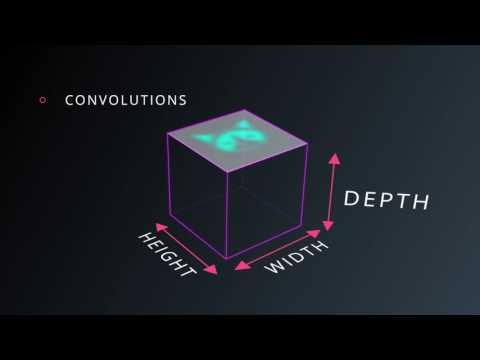

In [21]:
#@title Introducing CNN { vertical-output: true, display-mode: "code" }
#@markdown This is a very good introduction to convolutional neural networks
from IPython.display import YouTubeVideo
YouTubeVideo('ISHGyvsT0QY', width=600, height=400)

We can reduce spatial dimensions either by striding or pooling.

In our next approach we are including the spatial relations to increase the model performance. We start with a few Convolutional layers and reduce the dimensionalty with a single pooling layer before we continue with a fully-connected network (Flatten + Dense layers).

![alt text](https://cdn-images-1.medium.com/max/1500/1*8dx6nxpUh2JqvYWPadTwMQ.gif)


![alt text](https://cdn-images-1.medium.com/max/1500/1*CYB2dyR3EhFs1xNLK8ewiA.gif)

![alt text](https://cdn-images-1.medium.com/max/1000/1*RYYucIh3U-YFxrIkyQKzRw.gif)

In [22]:
img = Input((28, 28, 1))
x = Conv2D(32,3, padding="same", activation="relu")(img)
x = Conv2D(64,3, padding="same", activation="relu")(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dense(10, activation="softmax")(x)
model = Model(img, x)

model.summary()

opt = Adam(0.001)
model.compile(loss="categorical_crossentropy",optimizer=opt, metrics=["categorical_accuracy"])
history = model.fit(norm_x_train, categorical_y_train, epochs=20, batch_size=512, validation_split=0.2)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               1605760   
                                                           

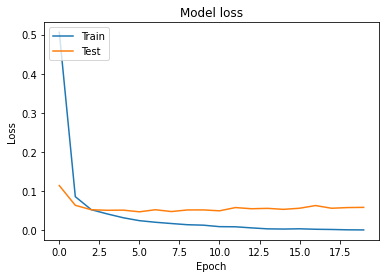

In [23]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Overfitting is one of the major problems in deep learning. As can be seen from the validation loss the network starts to memorize the training data.
This can be prevented either by limiting the model complexity or by using more data.

The commonly used steps to circumvent this are:
*   Change Architecture
*   Data augmentation
*   Weight decay (L1/L2)
*   Dropout
*   Early stopping

We have already applied early stopping by limiting the training epochs, now we add additional dropout layers which randomly switch off connections within the network. With this technique the network learns to find multiple paths which lead to a solution, this improves the performance and the generalization.

In [24]:
img = Input((28, 28, 1))
x = Conv2D(32,3, padding="same", activation="relu")(img)
x = Dropout(0.3)(x)
x = Conv2D(64,3, padding="same", activation="relu")(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dense(10, activation="softmax")(x)
model = Model(img, x)

model.summary()

opt = Adam(0.0005)
model.compile(loss="categorical_crossentropy",optimizer=opt, metrics=["categorical_accuracy"])
history = model.fit(norm_x_train, categorical_y_train, epochs=40, batch_size=512, validation_split=0.2)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 12544)             0         
                                                           

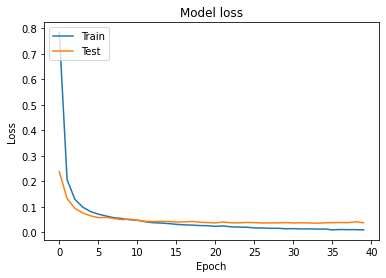

In [25]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

With this the training and validation loss decrease gradually together. Lets train the model on the full training set for the final prediction.

In [26]:
img = Input((28, 28, 1))
x = Conv2D(32,3, padding="same", activation="relu")(img)
x = Dropout(0.3)(x)
x = Conv2D(64,3, padding="same", activation="relu")(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dense(10, activation="softmax")(x)
model = Model(img, x)

model.summary()

opt = Adam(0.0005)
model.compile(loss="categorical_crossentropy",optimizer=opt, metrics=["categorical_accuracy"])
history = model.fit(norm_x_train, categorical_y_train, epochs=40, batch_size=512, validation_split=0)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 dropout_2 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 12544)             0         
                                                           

In [27]:
model.evaluate(norm_x_test, categorical_y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0306 - categorical_accuracy: 0.9901


[0.03059435822069645, 0.9901000261306763]

Thus, the use of convolutional layers leads to almost perfect predictions (1% error).

# CIFAR

![alt text](https://alexisbcook.github.io/assets/cifar10.png)

**Choose your weapons!**



```
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Activation, BatchNormalization, GaussianNoise, SeparableConv2D
from keras.optimizers import SGD, RMSprop, Adagrad, Adam, Adadelta, Adamax, Nadam
```
Change learning rate, batch size, loss and optimizer


Activations: relu, sigmoid, tanh, elu

```
x = Activation("tanh")(x)
```

Normalization for faster convergence (for images):

```
x = BatchNormalization()(x)
```

Striding instead of pooling:

```
x = Conv2D(... , strides=2)(img)
```

Try different kernel sizes, pooling steps and paddings:
```
x = Conv2D(filters=128, kernel_size=10, padding="valid", activation="relu", strides=2)(img)
```


https://keras.io/

In [28]:
from keras.datasets import cifar10

In [29]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [30]:
print("X-shape:", x_train.shape)
print("Y-shape:", y_train.shape)

X-shape: (50000, 32, 32, 3)
Y-shape: (50000, 1)


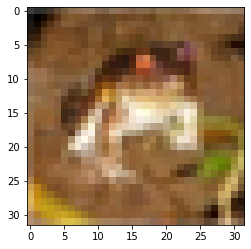

In [32]:
  plt.imshow(x_train[0])
  plt.show()